# Bank Note Authentication: Linear Classification

**Objective:** Fit a linear classifier (Logistic Regression) to the Bank Note Authentication dataset and evaluate performance. Investigate the effect of L2 regularization and outliers. Visualize key features in 3D.

## Import necessary libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from mpl_toolkits.mplot3d import Axes3D

## Load dataset and inspect

In [4]:
dataset = pd.read_csv("BankNote_Authentication.csv")

print("Columns Info:\n")
for col in dataset.columns:
    print(f"| {col} | {dataset[col].dtype} | {'Yes' if dataset[col].isna().any() else 'No'} |")

Columns Info:

| variance | float64 | No |
| skewness | float64 | No |
| curtosis | float64 | No |
| entropy | float64 | No |
| class | int64 | No |


## Prepare features and target, train-test split, and standardize features

In [5]:
# Features and target
X = dataset[['variance','skewness','curtosis','entropy']].values
y = dataset['class'].values  # 0 or 1

# Train-test split (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Logistic Regression with L2 Regularization

In [6]:
# Lambda values to test
lam_values = [0.01, 0.1, 1, 10, 100]
train_acc_list = []
test_acc_list = []

for lam in lam_values:
    clf = LogisticRegression(penalty='l2', C=1/lam, solver='liblinear', max_iter=1000)
    clf.fit(X_train_scaled, y_train)
    
    y_train_pred = clf.predict(X_train_scaled)
    y_test_pred = clf.predict(X_test_scaled)
    
    train_acc_list.append(accuracy_score(y_train, y_train_pred))
    test_acc_list.append(accuracy_score(y_test, y_test_pred))
    
    print(f"Lambda={lam}: Train Acc={train_acc_list[-1]:.4f}, Test Acc={test_acc_list[-1]:.4f}")

Lambda=0.01: Train Acc=0.9896, Test Acc=0.9903
Lambda=0.1: Train Acc=0.9917, Test Acc=0.9903
Lambda=1: Train Acc=0.9833, Test Acc=0.9782
Lambda=10: Train Acc=0.9781, Test Acc=0.9733
Lambda=100: Train Acc=0.9406, Test Acc=0.9296


## Logistic Regression without Regularization

In [9]:
clf_no_reg = LogisticRegression(penalty=None, solver='lbfgs', max_iter=1000)
clf_no_reg.fit(X_train_scaled, y_train)

print("\nNo Regularization: Train Acc =", accuracy_score(y_train, clf_no_reg.predict(X_train_scaled)),
      ", Test Acc =", accuracy_score(y_test, clf_no_reg.predict(X_test_scaled)))


No Regularization: Train Acc = 0.9885416666666667 , Test Acc = 0.9878640776699029


## Plot Train/Test Accuracy vs λ

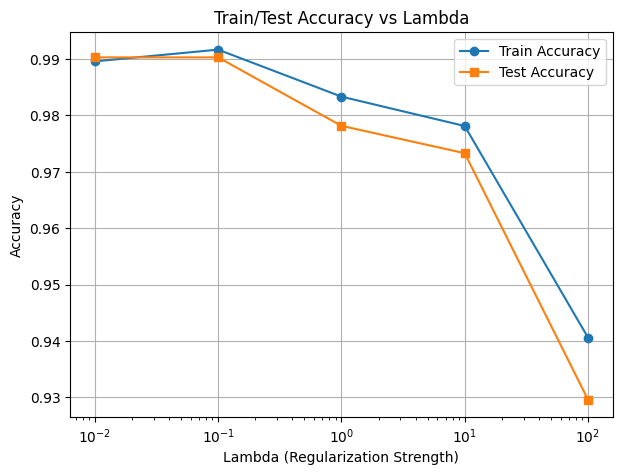

In [10]:
plt.figure(figsize=(7,5))
plt.plot(lam_values, train_acc_list, marker='o', label='Train Accuracy')
plt.plot(lam_values, test_acc_list, marker='s', label='Test Accuracy')
plt.xscale('log')
plt.xlabel("Lambda (Regularization Strength)")
plt.ylabel("Accuracy")
plt.title("Train/Test Accuracy vs Lambda")
plt.grid(True)
plt.legend()
plt.show()

## 3D Visualization of Top 3 Features

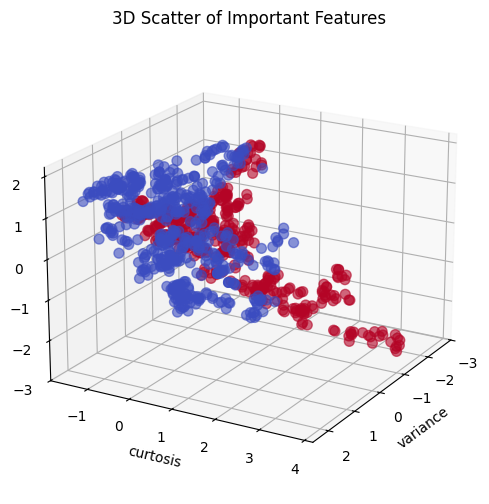

In [11]:
# Select top 3 features by coefficient magnitude from the best model (highest test accuracy)
best_idx = np.argmax(test_acc_list)
clf_best = LogisticRegression(penalty='l2', C=1/lam_values[best_idx], solver='liblinear', max_iter=1000)
clf_best.fit(X_train_scaled, y_train)

coef_abs = np.abs(clf_best.coef_[0])
top_features_idx = np.argsort(coef_abs)[-3:]
feature_names = ['variance','skewness','curtosis','entropy']
selected_features = [feature_names[i] for i in top_features_idx]

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(
    X_train_scaled[:,top_features_idx[0]], 
    X_train_scaled[:,top_features_idx[1]], 
    X_train_scaled[:,top_features_idx[2]], 
    c=y_train, cmap='coolwarm', s=50, alpha=0.6
)
ax.set_xlabel(selected_features[0])
ax.set_ylabel(selected_features[1])
ax.set_zlabel(selected_features[2])
ax.set_title("3D Scatter of Important Features")
ax.view_init(elev=20, azim=30)
plt.show()

## Introduce Outliers

In [12]:
X_train_outlier = X_train_scaled.copy()
np.random.seed(42)
outlier_idx = np.random.choice(range(X_train_outlier.shape[0]), size=5, replace=False)
X_train_outlier[outlier_idx] += np.random.normal(10, 5, size=(5, X_train_outlier.shape[1]))  # large shift

## Fit Classifier on Outlier-Injected Data

In [13]:
clf_outlier = LogisticRegression(penalty='l2', C=1.0, solver='liblinear', max_iter=1000)
clf_outlier.fit(X_train_outlier, y_train)

y_train_pred_out = clf_outlier.predict(X_train_outlier)
y_test_pred_out = clf_outlier.predict(X_test_scaled)

print("Outlier-Injected Data: Train Acc =", accuracy_score(y_train, y_train_pred_out),
      ", Test Acc =", accuracy_score(y_test, y_test_pred_out))

Outlier-Injected Data: Train Acc = 0.96875 , Test Acc = 0.9635922330097088


### Observations
1. Linear classification works well for this dataset; train/test accuracy is high (>95%).
2. L2 Regularization helps prevent overfitting for large λ values; small λ behaves like no regularization.
3. Outliers significantly impact test accuracy; model becomes less robust.
4. 3D feature visualization shows clear separation between the two classes in the top features.